We want to implement FE-FFT method using `Fenicsx` and `Spectral` methods.

Importing `Fenicsx` related modules. 

In [1]:
import dolfinx as df
import ufl
import basix
from mpi4py import MPI

from pathlib import Path
from typing import Dict

cache_dir = f"./dolfinx-cache/"
print(f"Directory to put C files in: {cache_dir}")

jit_options = {"cffi_extra_compile_args":  ["-O3", "-march=native"],
                "cache_dir": cache_dir, "cffi_libraries": ["m"]}

Directory to put C files in: ./dolfinx-cache/


Importing `Jax` related modules

In [2]:
import jax
jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update('jax_platforms', 'cpu')
from jax.typing import ArrayLike
from jax import Array
import functools

Importing `Spectral` methods helpers

In [3]:
import sys
sys.path.append('../fft_helpers/')
from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sys.path.append('../plot_helpers/')
plt.style.use(['../plot_helpers/prl_paper.mplstyle'])
from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

In [4]:
import numpy as np
from skimage.morphology import disk, rectangle

## macroscale problem

We define a rectangular domain at `macro` scale. 

In [5]:
length, height = 10.0, 1.0
Nx, Ny = 8, 2
domain = df.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([length, height])],
    [Nx, Ny],
    cell_type=df.mesh.CellType.quadrilateral,
)

dim = domain.topology.dim
print(f"Mesh topology dimension d={dim}.")

Mesh topology dimension d=2.


We use `Lagrange` shape functions of `degree=1` at the macro scale to interpolate displacement fields. 

In [6]:
gdim = domain.geometry.dim

deg_u = 1
shape = (gdim,)
V = df.fem.functionspace(domain, ("P", deg_u, shape))

In [7]:
V_ux, _ = V.sub(0).collapse()
V_uy, _ = V.sub(1).collapse()
left_dofs = df.fem.locate_dofs_geometrical(
    V, lambda x: np.isclose(x[0], 0.0)
)

bot_dofs = df.fem.locate_dofs_geometrical(
    V, lambda x: np.isclose(x[1], 0.0)
)
top_dofs = df.fem.locate_dofs_geometrical(
    (V.sub(1), V_uy), lambda x: np.isclose(x[1], height)
)

right_dofs = df.fem.locate_dofs_geometrical(
    (V.sub(1), V_uy), lambda x: np.isclose(x[0], length)
)



uD_y = df.fem.Function(V_uy)
epsr = 1e-1
uD_y.vector.set(epsr * length)
bcs = [
    df.fem.dirichletbc(np.zeros((2, )), left_dofs, V),
    df.fem.dirichletbc(uD_y, right_dofs, V.sub(1)),
]

In [12]:
deg_quad = 1  # quadrature degree for internal state variable representation

dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": deg_quad, "quadrature_scheme": "default"},
)
ds = ufl.Measure('ds', domain=domain, 
                 metadata={"quadrature_degree": deg_quad, "quadrature_scheme": "default"})



We also need function spaces for stresses and tangent matrix. To this end, we define 

In [13]:
vdim = 3 + 1  # dimension of the full vectorial representation of tensors
W0e = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(), scheme="default", degree=deg_quad
)

We = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(vdim, ), scheme="default", degree=deg_quad
)
WTe = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(vdim,vdim), scheme="default", degree=deg_quad
)


W = df.fem.functionspace(domain, We)
WT = df.fem.functionspace(domain, WTe)
W0 = df.fem.functionspace(domain, W0e)


sig = df.fem.Function(W, name="Stress")
Ct = df.fem.Function(WT, name="Tangent_operator")
eps = df.fem.Function(W, name="Total_strain")
eps_old = df.fem.Function(W, name="Previous_total_strain")

u = df.fem.Function(V, name="Total_displacement")
du = df.fem.Function(V, name="Iteration_correction")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

In [14]:
def gradu(v):
    F = ufl.grad(v)
    return ufl.as_tensor([F[0, 0], F[0, 1], F[1, 0], F[1, 1]])


residual_form = ufl.dot(gradu(u_), sig) * dx
tangent_form = ufl.dot(gradu(v), ufl.dot(Ct, gradu(u_))) * dx

In [15]:
basix_celltype = getattr(basix.CellType, domain.topology.cell_type.name)
quadrature_points, weights = basix.make_quadrature(basix_celltype, deg_quad)

map_c = domain.topology.index_map(domain.topology.dim)
num_cells = map_c.size_local + map_c.num_ghosts
cells = np.arange(0, num_cells, dtype=np.int32)
ngauss = num_cells * len(weights)

eps_expr = df.fem.Expression(gradu(u), quadrature_points)


def eval_at_quadrature_points(expression):
    return expression.eval(domain, cells).reshape(ngauss, -1)

## microscale problem using spectral method

We now define the microscale problem. We define a local microstructure with a inclusion. This micorstructure will be defined for each `gauss` point. The strains from the macro scale at each gauss point will be passed to each microstructure and from the microstructure the average stress and a tangent stiffness matrix is passed to the macroscale.  

We choose FFT based spectral method to solve the microstructure and get the local stresses as well as macro stress. To get the tangent stiffness matrix, we make use of the `jax` library and use the automatic differentation to compute the eact tangent operator.

Please check the following link for the inspiration
- [JAX](https://jax.readthedocs.io/en/latest/)
- [Fenicsx inspiration](https://bleyerj.github.io/comet-fenicsx/tours/nonlinear_problems/linear_viscoelasticity_jax/linear_viscoelasticity_jax.html)
- [More possiblity](https://github.com/a-latyshev/dolfinx-external-operator)

Now, we define the microscale RVE.

In [16]:
# material parameters
phase_constrast = 1/100.

elastic_modulus = {"solid": 5.7, "inclusion": phase_constrast*5.7}  # N/mm2
poisson_modulus = {"solid": 0.386, "inclusion": phase_constrast*0.386}


In [17]:
structure = np.load('./figs/blurred_lattice.npy')
structure = np.where(structure < 0.6, 0, 1)
H, L = structure.shape
size = np.minimum(H, L)
if size%2 == 0:
    size = size-1
structure = structure[:size, :size]

In [18]:
length = 1.
H, L = structure.shape
dx = length/H
dy = length/L

In [19]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [
    N,
] * ndim  # number of voxels in all directions

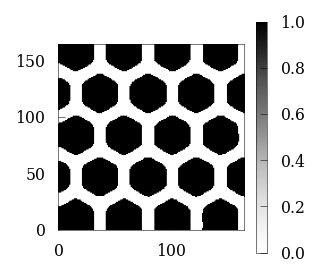

In [21]:
plt.figure(figsize=(2, 2))
cb = plt.imshow(structure, origin="lower", cmap='Greys')
plt.colorbar(cb)
plt.show()

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


## fft helpers and operators

In [22]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)  # 4th order Identity tensor
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4s = (I4 + I4rt) / 2.0

II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

In [23]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))

@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

The projection operator

In [24]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="rotated", length=1.0)

In [25]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['ones', 'zeros'])
def param(X, ones, zeros):
    return ones*jnp.ones_like(X)*(X)+zeros*jnp.ones_like(X)*(1-X)

In [26]:
# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

In [27]:
# material parameters
K      = param(structure,   ones=bulk_modulus['inclusion'],            zeros=bulk_modulus['solid']        )  # bulk      modulus
μ0     = param(structure,   ones=shear_modulus['inclusion'],           zeros=shear_modulus['solid']        )  # shear     modulus
λ0     = param(structure,   ones=lambda_modulus['inclusion'],          zeros=lambda_modulus['solid']        )  # shear     modulus

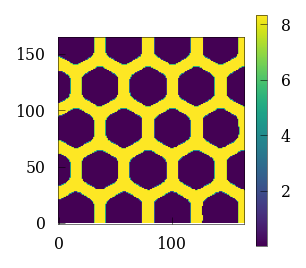

In [28]:
plt.figure(figsize=(2,2))
plt.imshow(K, origin='lower')
plt.colorbar()

## st-venant kirchhoff material

The strain energy function for a `St. Venant Kirchhoff` material (isotropic compresisble hyperelastic material) is given as 
\begin{align}
\psi(E) &= \dfrac{\lambda}{2}(\text{tr} E)^2 + \mu \text{tr}(E:E) \\ 
\end{align}

where `E= Green-Lagrange strain tensor` which can be related to the `deformation gradient F` as 
\begin{align}
E = \dfrac{1}{2}(F^{T}.F -I)
\end{align}

In [29]:
@jax.jit
def green_lagrange_strain(F : ArrayLike) -> Array:
    return .5*(tensor.dot22(tensor.trans2(F),F)-I)

@jax.jit
def strain_energy(F : ArrayLike) -> Array:
    E = green_lagrange_strain(F)
    E = 0.5*(E + tensor.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(E)**2) + jnp.multiply(μ0, tensor.trace2(tensor.dot22(E, E)))
    return energy.sum()

piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

Due to the `geometric nonlinearity` in the stress-strain relationship, we use a `Netwon-Raphson` scheme combined with `Conjugate gradient` to solve for the compatible strains within the RVE. 
\begin{align}
    \Delta \sigma_{ij} = \dfrac{\partial \sigma_{ij}(F)}{\partial F_{ij}}\Delta F_{ij}
\end{align}

In [30]:
# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tensor.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

In [31]:
@functools.partial(jax.jit, static_argnames=['piola_kirchhoff'])
def G_P(dF, F, piola_kirchhoff):
    dF = dF.reshape(ndim,ndim,N,N)
    tangents = jax.jvp(piola_kirchhoff, (F,), (dF,))[1] ## to compute the jvp at F in the direction of dF to get the correct incremental stress
    return G(tangents)

## newton-krylov solver

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method and and a `krylov` solver such as `conjugate gradient`

In [32]:
@functools.partial(jax.jit, static_argnames=['A', 'K'])
def conjugate_gradient(A, b, additional, K,  atol=1e-5):

    b, additional = jax.device_put((b, additional))

    def body_fun(state):
        b, p, r, rsold, x =  state
        Ap = A(p, additional, K) 
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r) 
        p = r + (rsnew/rsold)*p
        rsold = rsnew
        return (b, p, r, rsold, x)

    def cond_fun(state):
        b, p, r, rsold, x = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)
    p = r
    rsold = jnp.vdot(r, r) 

    b, p, r, rsold, x = jax.lax.while_loop(cond_fun, body_fun, (b, p, r, rsold, x) )
    return x

In [33]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)
       
    def true_fun(state):
        dF, b, F, Fn = state
        #P, P_jvp = jax.linearize(piola_kirchhoff, F)

        dF = conjugate_gradient(
                atol=1e-6, 
                A = G_P,
                b = b,
                additional = F,
                K = piola_kirchhoff,
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tens.grid)
        P      = piola_kirchhoff(F)         # new residual stress
        b      = -G(P)                      # convert residual stress to residual

        return (dF,  b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-5, true_fun, false_fun, state), n

In [34]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps  =  jnp.array(I, copy=True)  # to convert grad u to deformaiton gradient

    # set macroscopic loading
    DE       = jnp.zeros([ndim,ndim,N,N])
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[0, 1].set(macro_strain[1])
    DE = DE.at[1, 0].set(macro_strain[2])
    DE = DE.at[1, 1].set(macro_strain[3])

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_P(DE, eps, piola_kirchhoff)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_netwon_raphson, 
                               init=initial_state, 
                               xs=jnp.arange(0, 10))
    

    DE, b, eps, En = final_state
    P = piola_kirchhoff(eps)

    # get the macro stress
    macro_sigma = jnp.array([jnp.mean(P.at[0, 0].get()), jnp.mean(P.at[0, 1].get()), jnp.mean(P.at[1, 0].get()),  jnp.mean(P.at[1, 1].get())])
    
    return macro_sigma, (macro_sigma, P, eps)

In [35]:
tangent_operator_and_state = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
))

In [36]:
deps = jnp.array([1e-3, 2e-2, 2e-2, 6e-3])

In [37]:
tangent, state = tangent_operator_and_state(deps)

residual=0.02038181100725376
residual=0.026391482005443907
residual=0.003385078943146867
residual=0.000416367132643983
residual=1.317624842358357e-06
residual=1.317624842358357e-06
residual=1.317624842358357e-06
residual=1.317624842358357e-06
residual=1.317624842358357e-06
residual=1.317624842358357e-06


In [38]:
tangent

Array([[1.44836327, 0.07402296, 0.08090431, 0.67680152],
       [0.07402311, 0.23005656, 0.22299022, 0.04021823],
       [0.08090446, 0.22299022, 0.23199611, 0.03768054],
       [0.67680156, 0.04021822, 0.03768053, 1.25916162]], dtype=float64)

In [39]:
plt.figure(figsize=(2, 2))
plt.imshow(state[1].at[1, 1].get(), origin='lower')
plt.colorbar()

In [40]:
batched_constitutive_update = jax.jit(
    jax.vmap(tangent_operator_and_state, in_axes=(0))
)

In [41]:
gauss_sigs = np.zeros([ngauss, ndim, ndim, structure.shape[0], structure.shape[1]])
gauss_eps = np.zeros([ngauss, ndim, ndim, structure.shape[0], structure.shape[1]])

In [42]:
def constitutive_update(u, sig, eps_old, gauss_sigs, gauss_eps):
    with df.common.Timer("Constitutive update"):
        eps_values = eval_at_quadrature_points(eps_expr)        
        Ct_values, state = batched_constitutive_update(
            eps_values
        )
        
        sig_values, local_sigs, local_eps = state

        sig.x.array[:] = sig_values.ravel()
        Ct.x.array[:] = Ct_values.ravel()

        gauss_sigs[:] = local_sigs[:]        
        gauss_eps[:] = local_eps[:]

## solving

In [43]:
from solvers import CustomLinearProblem, CustomNewtonSolver

In [44]:
tangent_problem = CustomLinearProblem(
    tangent_form,
    -residual_form,
    u=du,
    bcs=bcs,
    jit_options=jit_options,

    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
)


In [45]:
newton = CustomNewtonSolver(tangent_problem)
newton.callback = constitutive_update

In [46]:
sig.vector.set(0.0)
u.vector.set(0.0)

state = (sig,  eps_old, gauss_sigs, gauss_eps)
niter, converged = newton.solve(u, *state)

residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0

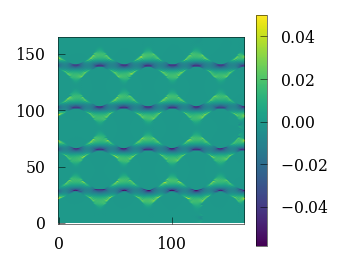

In [47]:
plt.figure(figsize=(2, 2))
plt.imshow(gauss_sigs[0][1, 1], origin='lower')
plt.colorbar()
plt.show()

In [44]:
vtk = df.io.VTKFile(domain.comm, "../output/multiscale_lattice.pvd", "w")
vtk.write_function(u)
vtk.write_function(sig)
vtk.close()

In [48]:
u_topology, u_cell_types, u_geometry = df.plot.vtk_mesh(V)

In [49]:
import matplotlib.tri as tri
import matplotlib.patches as mpatches

In [50]:
x = u_geometry[:, :2]# + u_mat
triang = tri.Triangulation(x=x[:, 0], y=x[:, 1])

In [51]:
x = ufl.SpatialCoordinate(domain)
x_expr = df.fem.Expression(x+u, quadrature_points)

In [52]:
quad_values = eval_at_quadrature_points(x_expr)

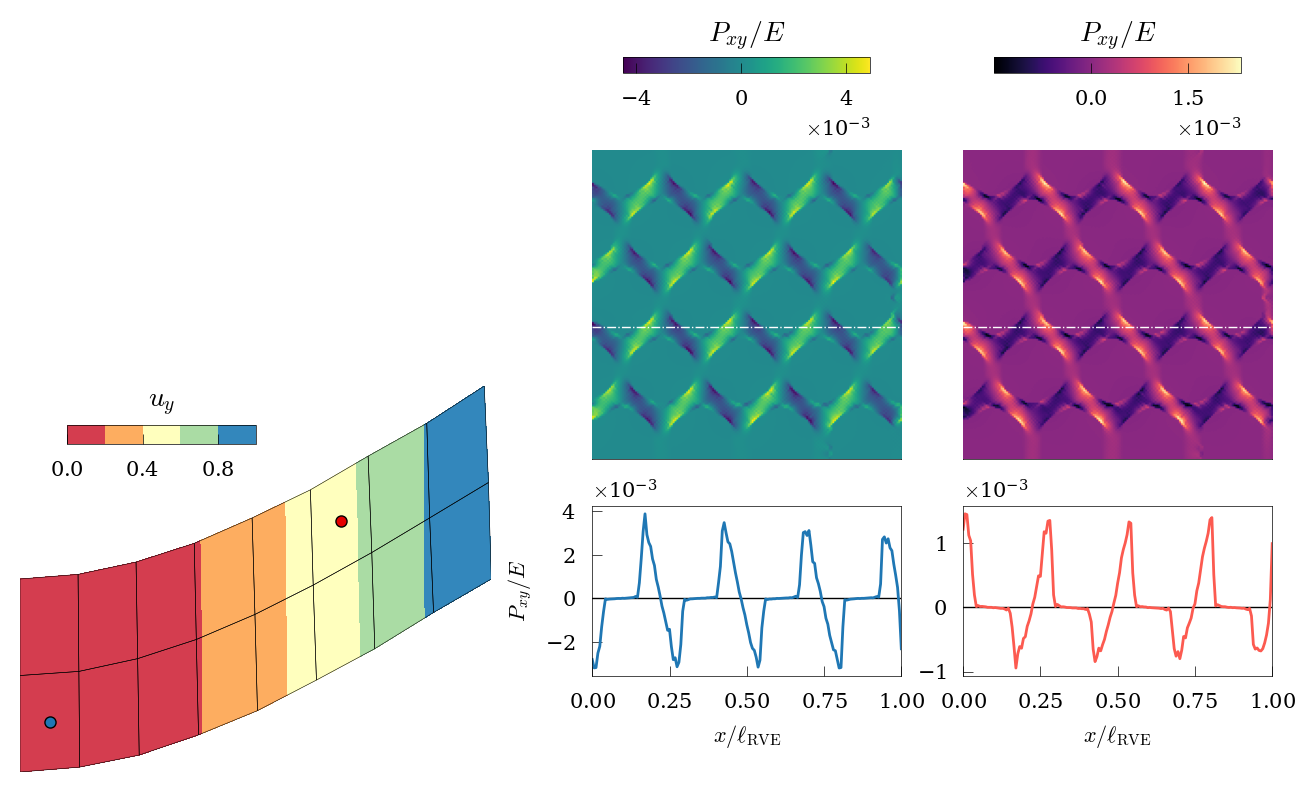

In [89]:
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

u_mat = u.x.array.reshape(-1, 2)

refiner = tri.UniformTriRefiner(triang)
tri_refi, ux_test_refi = refiner.refine_field(u_mat[:, 0], subdiv=0)
tri_refi, uy_test_refi = refiner.refine_field(u_mat[:, 1], subdiv=0)

fig = plt.figure(figsize=set_size(width='two-column', fraction=0.95, height_ratio=0.55),
                 constrained_layout=True, dpi=200)

gs1 = GridSpec(2, 1, height_ratios=[0.5, 1], left=0.05, right=0.4, bottom=0.02) #width_ratios=[0.5, 0.8, 0.8], height_ratios=[1, 0.5])
ax = fig.add_subplot(gs1[1, 0])

for cell_index in u_topology.reshape(-1, 5)[:, 1:]:
    polygon = mpatches.Polygon(u_geometry[cell_index][:, :2] + u_mat[cell_index], 
                               closed=True, ec='k', fc='None', zorder=20, linewidth=0.2)
    ax.add_patch(polygon)

cs=ax.tricontourf(tri_refi.x + ux_test_refi, tri_refi.y + uy_test_refi, tri_refi.triangles,  uy_test_refi, cmap='Spectral', vmin=0, levels=4)
ax.scatter(quad_values[0][0], quad_values[0][1], c='tab:blue', edgecolors='k', linewidths=0.5)
ax.scatter(quad_values[11][0], quad_values[11][1], c='xkcd:red', edgecolors='k', linewidths=0.5)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
axins1 = ax.inset_axes([0.1, 0.85, 0.4, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(r'$u_{y}$', fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  
ax.axis('off')
#ax.set_aspect(1/ax.get_data_ratio())


gs2 = GridSpec(2, 2, height_ratios=[1, 0.5], width_ratios=[1, 1], left=0.475, right=0.98, bottom=0.15) #width_ratios=[0.5, 0.8, 0.8], height_ratios=[1, 0.5])
gs2.update(hspace=0.125)
ax = fig.add_subplot(gs2[0, 0])

quantity=gauss_sigs[0][0, 1]/elastic_modulus['solid']
title=r'$P_{xy}/E$'
vmin = np.min(quantity)
vmax = np.max(quantity)
 
cs = ax.imshow(quantity, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, zorder=10, )
ax.axhline(y=70, c='w', zorder=20,  lw=0.5, ls='dashdot')


axins1 = ax.inset_axes([0.1, 1.25, 0.8, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(title, fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  
cbar.formatter.set_powerlimits((0, 0))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


xx = np.linspace(0, 1, len(gauss_sigs[0][0, 1][70, :]))

ax = fig.add_subplot(gs2[1, 0])

ax.plot(xx, gauss_sigs[0][0, 1][70, :]/elastic_modulus['solid'])
ax.axhline(y=0, c='k', zorder=-1,  lw=0.5)
ax.set_xlim(left=0, right=1)
ax.set_xlabel(r'$x/\ell_\mathrm{RVE}$')
ax.set_ylabel(r'$P_{xy}/E$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -4))


ax = fig.add_subplot(gs2[0, 1])

quantity=gauss_sigs[11][0, 1]/elastic_modulus['solid']
title=r'$P_{xy}/E$'
vmin = np.min(quantity)
vmax = np.max(quantity)
 
cs = ax.imshow(quantity, origin='lower', cmap='magma', vmin=vmin, vmax=vmax, zorder=10)
ax.axhline(y=70, c='w', zorder=20,  lw=0.5, ls='dashdot')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

axins1 = ax.inset_axes([0.1, 1.25, 0.8, 0.05])

cbar = fig.colorbar(cs, cax=axins1, pad=0.05, 
                      fraction=0.025, shrink=.5, orientation="horizontal")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(title, fontsize=10, labelpad=-32, y=0.85)
cbar.ax.yaxis.set_offset_position('right')  
cbar.formatter.set_powerlimits((0, 0))


ax = fig.add_subplot(gs2[1, 1])

ax.plot(xx, gauss_sigs[11][0, 1][70, :]/elastic_modulus['solid'],c='xkcd:coral',)
ax.axhline(y=0, c='k', zorder=-1,  lw=0.5)
ax.set_xlim(left=0, right=1)
ax.set_xlabel(r'$x/\ell_\mathrm{RVE}$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, -4))


plt.savefig('./figs/paper_multiscale_lattice.svg')
plt.show()

In [57]:
df.common.list_timings(MPI.COMM_WORLD, [df.common.TimingType.wall])


[MPI_MAX] Summary of timings                                                |  reps    wall avg     wall tot
------------------------------------------------------------------------------------------------------------
Build dofmap data                                                           |     5    0.000000     0.000000
Build sparsity                                                              |     1    0.000000     0.000000
Compute dof reordering map                                                  |     5    0.000000     0.000000
Compute local part of mesh dual graph                                       |     1    0.000000     0.000000
Compute local-to-local map                                                  |     1    0.000000     0.000000
Compute-local-to-global links for global/local adjacency list               |     1    0.000000     0.000000
Constitutive update                                                         |     5  269.076000  1345.380000
Distribute row-wis